In [1]:
using Plots
using LinearAlgebra

### Άσκηση Α1 (α)
Υπολογίστε τη μάζα και το κέντρο βάρους κύβου μοναδιαίας ακμής και πυκνότητας $\rho(x,y,z) = 1 + x^2 + 2y^2 + 3z^2$ με ακρίβεια 1%. Θεωρήστε ότι η αρχή των συντεταγμένων είναι το σημείο (0,0,0)

Εν ολίγοις, θέλουμε τις εξής ποσότητες:

$$M = \int_D\rho(\vec r)d\vec r = \int_0^1\int_0^1\int_0^1\rho(x,y,z)dxdydz$$

$$\overrightarrow C = \int_D\vec r\rho(\vec r)d\vec r \implies C_i = \int_0^1\int_0^1\int_0^1r_i\rho(x,y,z)dxdydz$$

In [2]:
function density(x::Float64, y::Float64, z::Float64)::Float64
    1 + x ^ 2 + 2 * y ^ 2 + 3 * z ^ 2
end

density (generic function with 1 method)

In [3]:
struct IntervalParams
    lower::Float64
    upper::Float64
    partitions::Integer
end

g3r = [-0.7745966692, 0.0, 0.7745966692]
g3w = [0.5555555556, 0.8888888888, 0.5555555556]

function gauss3_1d(params::IntervalParams, f::Function)::Float64
    result = 0.0
    h = (params.upper - params.lower) / params.partitions

    for i = 0:(params.partitions - 1)
        xi = params.lower + h * i
        
        roots::Vector{Float64} = 0.5 * (h * g3r .+ (2 * xi + h))
        
        result += dot(g3w, map.(f, roots))
    end
    
    return result * 0.5 * h
end

function gauss3_1d(a::Float64, b::Float64, N::Integer, f::Function)::Float64
    gauss3_1d(IntervalParams(a,b,N), f)
end

gauss3_1d (generic function with 2 methods)

In [4]:
# accuracy test
function g(x::Float64) x ^ 6 - x ^ 2 * sin(2 * x) end

gauss3_1d(1.0, 3.0, 10, g)

317.3442466212831

Στο 1-D, οποιαδήποτε μέθοδος χρησιμοποιούμε είναι ένα συναρτησοειδές $\mathcal M:(\mathbb R\to\mathbb R)\to\mathbb R$

Στο d-D, ορίζουμε συναρτησοειδή ως προς τις μεταβλητές $x_i$: $\mathcal M_i:(\mathbb R^{d-i}\to\mathbb R)\to(\mathbb R^{d-i-1}\to\mathbb R)$ τέτοια ώστε:

$$\int_{\Delta_0}f(\vec x\,)dx_0 \approx \mathcal M_0[f],\quad \int_{\Delta_1}dx_1\int_{\Delta_0}dx_0f(\vec x) \approx \mathcal M_1\big[\mathcal M_0[f]\big],\dots$$

Για όλο τον κύβο:

$$
\begin{align}
    \int_{\mathcal D}f(\vec x)d\vec x &= \mathcal M_{d-1}\Big[\dots\mathcal M_1\big[\mathcal M_0[f]\big]\Big]
\end{align}
$$

In [5]:
function integrate_rect_2d(params::Vector{IntervalParams}, f::Function, integration_method::Function)::Float64
    return integration_method(
        params[2], 
        y -> integration_method(
            params[1], 
            x -> f(x,y)
        )
    )
end

integrate_rect_2d (generic function with 1 method)

In [6]:
# accuracy test
function test2d(x::Float64, y::Float64)::Float64 exp(x) + exp(y) end


result0 = integrate_rect_2d(
    [IntervalParams(0.0, 4.0, 1), IntervalParams(0.0, 4.0, 1)], 
    test2d, gauss3_1d
)
result1 = integrate_rect_2d(
    [IntervalParams(0.0, 4.0, 10), IntervalParams(0.0, 4.0, 10)], 
    test2d, gauss3_1d
)
result0, result1

(428.24278931419815, 428.7851993986164)

In [7]:
function integrate_rect_3d(params::Vector{IntervalParams}, f::Function, integration_method::Function)::Float64
    return integration_method(
        params[3], 
        z -> integration_method(
            params[2], 
            y -> integration_method(
                params[1],
                x -> f(x,y,z)
            )
        )
    )
end

integrate_rect_3d (generic function with 1 method)

In [8]:
a = 0.0; b = 1.0

function get_cube_params(a, b, N)
    edge = IntervalParams(a, b, N)
    return [edge, edge, edge]
end

[
    integrate_rect_3d(get_cube_params(a, b, N), density, gauss3_1d)
    for N = [1, 2, 4, 8]
]

4-element Vector{Float64}:
 2.999999999986446
 2.9999999999966116
 2.9999999999991536
 2.999999999999789

In [9]:
function tail(v::Vector) v[2:length(v)] end

function integrate_rect_Nd(
    variables::Vector{Float64}, params::Vector{IntervalParams}, 
    f::Function, integration_method::Function
)::Float64
    if length(params) == 0
        return f(variables)
    end
    
    return integration_method(
        params[1],
        x -> integrate_rect_Nd(
            vcat([x], variables), tail(params), f, integration_method
        )
    )
end

function integrate_rect_Nd(
    params::Vector{IntervalParams}, f::Function, integration_method::Function
)::Float64
    variables::Vector{Float64} = []
    integrate_rect_Nd(variables, params, f, integration_method)
end

integrate_rect_Nd (generic function with 2 methods)

In [10]:
function density(r::Vector{Float64}) density(r[1], r[2], r[3]) end

mass = [
    integrate_rect_Nd(get_cube_params(a, b, N), density, gauss3_1d)
    for N = [1, 2, 4, 8]
] # gives the same results as before!

4-element Vector{Float64}:
 2.999999999986446
 2.9999999999966116
 2.9999999999991536
 2.999999999999789

In [11]:
function estimate_error_2n(result_n::Float64, result_2n::Float64, order::Integer)
    abs(result_2n - result_n) / (2 ^ (order - 1) - 1)
end

[
    estimate_error_2n(mass[1], mass[2], 6)
    estimate_error_2n(mass[3], mass[4], 6)
]

2-element Vector{Float64}:
 3.2792406782831557e-13
 2.0499730945014182e-14

#### Υπολογισμός κέντρου βάρους

In [12]:
[
    [
        integrate_rect_Nd(get_cube_params(a, b, N), r -> r[i] * density(r), gauss3_1d)
        for i = 1:3
    ]
    for N = [1, 2, 4, 8]
]

4-element Vector{Vector{Float64}}:
 [1.5833333333242972, 1.6666666666553716, 1.749999999986446]
 [1.5833333333310744, 1.666666666663843, 1.7499999999966114]
 [1.5833333333327686, 1.6666666666659609, 1.7499999999991531]
 [1.583333333333192, 1.6666666666664902, 1.7499999999997886]

### Άσκηση Α1 (β)
Υπολογίστε με ακρίβεια 0.1% την ροπή αδράνειας σφαίρας μοναδιαίας ακτίνας και πυκνότητας $\rho = 1 + e^r$ ως προς άξονα που περνά από το κέντρο της σφαίρας. Θα χρησιμοποιήσουμε την προσαρμοζόμενη μέθοδο.

Εν ολίγοις, θέλουμε την εξής ποσότητα:

$$I = \int_0^1 r^2\rho(r)dr$$

In [13]:
function simpson_1d(a::Float64, b::Float64, f::Function)::Float64
    ((b - a) / 6) * (f(a) + f(b) + 4 * f((a + b) / 2))
end

function adjustor_1d(
    a::Float64, b::Float64, tolerance::Float64, 
    f::Function, integration_method::Function, method_order::Int64
)::Float64
    S0 = integration_method(a, b, f) # "zeroth" order approximation
    
    midpoint = 0.5 * (a + b)
    S1 = integration_method(a, midpoint, f) + 
         integration_method(midpoint, b, f) # "first" order approximation
    
    if abs(S0 - S1) < tolerance * S1 / (2 ^ (method_order - 1) - 1)
        return S1
    end
    
    return adjustor_1d(a, midpoint, 0.5 * tolerance, f, integration_method, method_order) + 
           adjustor_1d(midpoint, b, 0.5 * tolerance, f, integration_method, method_order)
end

adjustor_1d (generic function with 1 method)

In [14]:
# accuracy test
function g(x::Float64) x ^ 6 - x ^ 2 * sin(2 * x) end

adjustor_1d(1.0, 3.0, 0.1, g, simpson_1d, 5)

317.3962362243356

In [15]:
function radial_density(r::Float64) 1 + exp(r) end

function gauss3_1d(a::Float64, b::Float64, f::Function) gauss3_1d(a, b, 1, f) end

function moment_of_inertia(r) r ^ 2 * radial_density(r) end

[
    adjustor_1d(0.0, 1.0, 0.2, moment_of_inertia, simpson_1d, 5)
    adjustor_1d(0.0, 1.0, 0.2, moment_of_inertia, gauss3_1d, 6)
]

2-element Vector{Float64}:
 1.0522415712799635
 1.0516146710593184

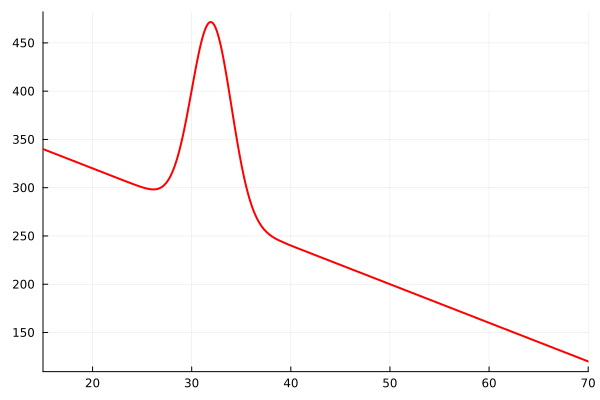

In [38]:
function gauss(x::Float64, mean::Float64, sigma::Float64)::Float64
    exp(-0.5 * ((x - mean) / sigma) ^ 2) / (sqrt(2 * pi) * sigma)
end

function peak(x::Float64)::Float64
    400 - 4 * x + 1000 * gauss(x, 32.0, 2.0)
end

plot(
    peak,
    xlimits = (15, 70),
    color = :red,
    linewidth = 2,
    label = ""
)

In [37]:
adjustor_1d(15.0, 70.0, 1.0, peak, gauss3_1d, 6)

13650.41036758366